# Option Pricing using Monte Carlo with antithetic variance reduction method 

It is given that from the Black-Scholes model and under the risk-free measures, we have that the stock's price can be modelled as 
$$ S_t = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W}_t\right) $$
where $ S_t $ is the stock price at time $ t  $, $ S_0  $ is the stock price at time $ t = 0 $, $ r $ is the risk-free rate, $ \sigma $ is the volatility of the stock, and $ \tilde{W}_t $ is a Brownian motion under the risk-free measure. To value the call price of a option with the above stock as the underlying asset, it can also be derived from Black-Scholes model that the call price at time $ t= 0$, is given by 
$$ C_0 = \exp(-rT) \tilde{\mathbb{E}}[\max(S_T - K , 0)] $$
where $ T $ is the maturity time and  $ K $ is the strike price.

A closed form can also be obtained as 
$$ C_0 = S_0 \Phi(d_1 ) - \exp(-r T) K \Phi(d_2 ) $$
where 
$$ d_1 = \cfrac{\log \frac{S_0}{K} + (r + \frac{\sigma^2}{2}  )T}{\sigma \sqrt{T}}  $$
$$ d_2 = \cfrac{\log \frac{S_0 }{K} + (r - \frac{\sigma^2}{2} )T }{ \sigma \sqrt{T}}  $$
where 
$$ \Phi(x) = \frac{1}{\sqrt{2\pi}} \int\limits_{-\infty }^{x } \exp (- t^2 / 2) dt   $$
Using Monte Carlo we can do the following approximation 
$$ \tilde{\mathbb{E}}[\max(S_T - K, 0)] \approx \frac{1}{N} \sum\limits_{j = 1 }^{N} \max[S_T^j - K , 0]  $$
where $S_T^j$ is the $j$-th Brownian paths of $S_T$. 

# Antithetic variance reduction method
We can write the $j$-th Brownian path of the stock price $S_t$ as 
   $$ S_t^j = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W}_t^j \right) $$
the use the antithetic variance reduction method, we will compute two Brownian paths for the stock price that are perfectly negatively correlated. The two paths are given by 
   $$ S_t^j = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t + \sigma \tilde{W}_t^j \right) $$
   $$\overline{S_t^j } = S_0 \exp\left(\left(r - \frac{\sigma^2}{2} \right) t - \sigma \tilde{W}_t^j \right) $$
   then the analogous approximation as stated earlier will be 
   $$ \tilde{\mathbb{E}}[\max(S_T - K , 0)] \approx \frac{1}{N} \sum\limits_{j =1}^{N } \frac{\max(S_T^j - K ,0 ) + \max(\overline{S_T^j } - K , 0)}{2}  $$
   We will compare the performances between the antithetic variance reduction method and the standard Monte Carlo method in valueting option. 

## Importing dependencies

In [235]:
# importing dependencies
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.stats as ss

## Obtaining values of market $C_0$, implied volatility $\sigma$, strike price $K$, underlying stock price $S_0$, maturity $T$ (in years), risk-free rate $r$

In [236]:
# sample data obtained from ASX
sigma = 0.0991
K = 98.01
S0 = 101.15
T = 0.164383561
r = 0.01

## Implementing the function for Black-Scholes option pricing formula

In [237]:
def BS_option_call(*, maturity, S0, rfr, strike, time = 0, vol):
    import numpy as np 
    from scipy.stats import norm

    if time > strike:
        raise 'Time parameter is more than maturity parameter'
    
    d1 = (np.log(S0 / strike)  + (rfr + vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    d2 = (np.log(S0 / strike)  + (rfr - vol**2 /2) * (maturity - time)) / (vol * np.sqrt(maturity - time))
    return S0 * norm.cdf(d1) - np.exp(- rfr * (maturity - time)) * strike * norm.cdf(d2)

In [238]:
# option pricing using Black-Scholes option pricing model
C0_BS = BS_option_call(maturity = T, S0 = S0, rfr = r, strike = K, vol = sigma)
C0_BS

3.75998506175938

# Option pricing using standard Monte Carlo

## Defining our Brownian motion and Geometric Brownian motion functions

The derivation of the following functions can be found in another project called [MonteCarlo-GeometricBrownianMotion](https://github.com/nimnuhc/MonteCarlo-GeometricBrownianMotion.git)

In [239]:
def BM(vis = True,*, time, steps, samples):
    import numpy as np
    import matplotlib.pyplot as plt
    n = steps+1
    T = time 
    d = samples 
    times = np.linspace(0, T, n)
    dB = np.sqrt(times[1]) * np.random.normal(size = (n-1, d)) # n-1 rows because B0 is 0, so we exclude that 
    B0 = np.zeros(shape = (1,d)) 
    Bt = np.concatenate((B0, np.cumsum(dB, axis = 0)), axis = 0)
    if vis:
        plt.plot(times, Bt)
        plt.show()
        return times, Bt
    else:
        return times, Bt

def GBM(vis = True, *, S0, time, steps, samples, vol, rfr):
    import numpy as np 
    import matplotlib.pyplot as plt
    times, Bt = BM(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St
    else: 
        return times, St

# a slight modification to our original GBM functions found in the other project mentioned
# this GBM_AVR produces two paths that are perfectly negatively correlated
def GBM_AVR(vis = True, *, S0, time, steps, samples, vol, rfr):
    import numpy as np 
    import matplotlib.pyplot as plt
    times, Bt = BM(vis = False, time = time, steps = steps, samples = samples)
    times_d = np.tile(times, (samples,1)).T 
    St = S0 * np.exp((rfr - vol**2 /2)* times_d + vol * Bt)
    nSt = S0 * np.exp((rfr - vol**2 /2)* times_d - vol * Bt)
    if vis:
        plt.plot(times, St)
        plt.show()
        return times, St, nSt
    else: 
        return times, St, nSt


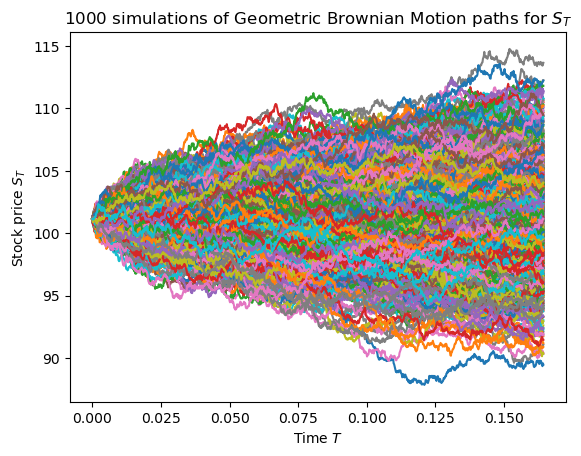

In [240]:
n = 1000 # discretisation 
d = 1000 # number of simulations
times, St = GBM(S0 = S0, time = T, vol = sigma, rfr = r, steps = n, samples = d, vis = False)
plt.plot(times, St)
plt.xlabel(r'Time $T$')
plt.ylabel(r'Stock price $S_T$')
plt.title(r'{} simulations of Geometric Brownian Motion paths for $S_T$'.format(n))
plt.show()

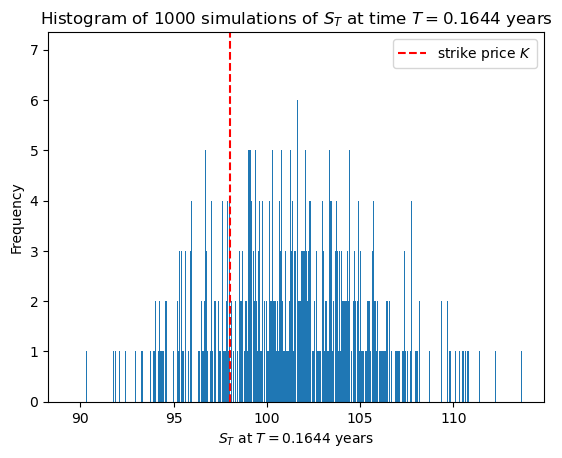

In [241]:
# visualising the distribution of the stock price at time t = T= 1
St1 = St[-1]

plt.hist(St1, bins = 1000)
plt.xlabel('$S_T$ at $T =${:.4f} years'.format(T))
plt.ylabel("Frequency")
plt.title('Histogram of {} simulations of $S_T$ at time $T=${:.4f} years'.format(n, T))
plt.axvline(x= K, color = 'red', label = r'strike price $K$', linestyle = 'dashed')
plt.legend()
plt.show()

In [242]:
# estimating the expected call return 
St1 = St[-1]
St1 = St1 - K 
C0_MC = np.exp(-r * T) * St1[St1 > 0].sum() / St.shape[1] 
C0_MC

3.6225836904760786

In [250]:
error = (np.abs(C0_MC - C0_BS) / C0_BS) * 100
print('Monte Carlo simulation option pricing: ', C0_MC)
print('Analytical Black-Scholes option pricing: ', C0_BS)  
print('Percentage error: ', error, '%')

Monte Carlo simulation option pricing:  3.6225836904760786
Analytical Black-Scholes option pricing:  3.75998506175938
Percentage error:  3.654306307775819 %


In [244]:
# computing the standard error of the estimator
St1[St1 <= 0 ] = 0 
SE1 = St1.std(ddof = 1) / np.sqrt(d)
SE1

0.1048830235373865

# Option pricing using Monte Carlo method with antithetic variance reduction method. 

Let's try 1000 simulations for now. I.e we get 1000 Brownian paths of $S_T$ and 1000 Brownian paths of $\overline{S_T}$. 

In the above plot of the Brownian paths simulations of $S_T$, here I will graph out the Brownian paths of $\overline{S_T}$ just to see if there's any noticable differences.

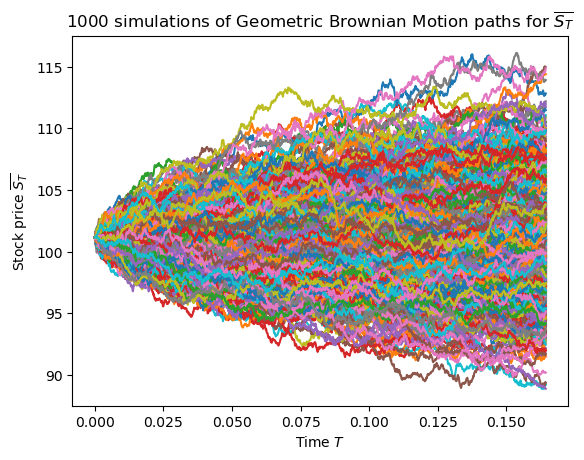

In [245]:
n = 1000 # discretisation 
d = 1000 # number of simulations
times, St, nSt = GBM_AVR(S0 = S0, time = T, vol = sigma, rfr = r, steps = n, samples = d, vis = False)
plt.plot(times, nSt)
plt.xlabel('Time $T$')
plt.ylabel('Stock price $\\overline{S_T}$')
plt.title('{0} simulations of Geometric Brownian Motion paths for $\\overline{{S_T}}$'.format(n))
plt.show()

In [246]:
# computing our MC with AVR estimator
St1 = St[-1] - K
St2 = nSt[-1] - K
C0_MC_AVR = np.exp(-r * T) * (St1[St1 > 0].sum() + St2[St2 > 0].sum())  / (St.shape[1] * 2)
C0_MC_AVR

3.776442715044028

In [251]:
# computing the error in estimating the Black-Scholes option pricing
error = (np.abs(C0_MC_AVR - C0_BS) / C0_BS) * 100
print('MC simulation with AVR option pricing: ', C0_MC_AVR)
print('Analytical Black-Scholes option pricing: ', C0_BS)  
print('Percentage error: ', error, '%')

MC simulation with AVR option pricing:  3.776442715044028
Analytical Black-Scholes option pricing:  3.75998506175938
Percentage error:  0.4377052837796849 %


In [248]:
# computing the standard error (SE) of our AVR estimator
St1[St1 <= 0] = 0 
St2[St2 <= 0] = 0 
S = 0.5 * (St1 + St2)
SE2 = S.std(ddof= 1) / np.sqrt(d)
SE2

0.02945695679099014

## Visualising the standard error of both estimators and the relative error in estimations.

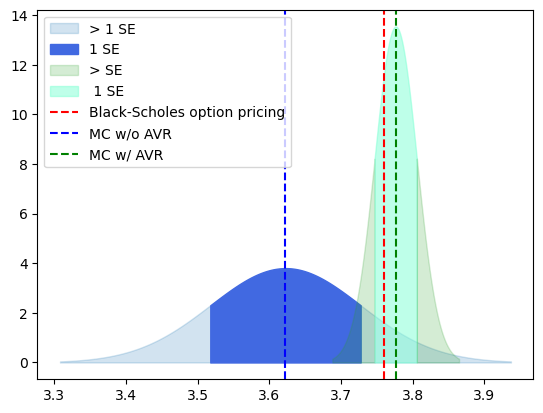

In [249]:
x1 = np.linspace(C0_MC - 3 * SE1, C0_MC - 1 * SE1, 100)
X1 = np.linspace(C0_MC_AVR - 3 * SE2, C0_MC_AVR - 1 * SE2, 100)
x2 = np.linspace(C0_MC - 1 * SE1, C0_MC + 1 * SE1, 100)
X2 = np.linspace(C0_MC_AVR - 1 * SE2, C0_MC_AVR + 1 * SE2, 100)
x3 = np.linspace(C0_MC + 1 * SE1, C0_MC + 3 * SE1, 100)
X3 = np.linspace(C0_MC_AVR + 1 * SE2, C0_MC_AVR + 3 * SE2, 100)

y1 = ss.norm.pdf(x1, C0_MC, SE1)
Y1 = ss.norm.pdf(X1, C0_MC_AVR, SE2)
y2 = ss.norm.pdf(x2, C0_MC, SE1)
Y2 = ss.norm.pdf(X2, C0_MC_AVR, SE2)
y3 = ss.norm.pdf(x3, C0_MC, SE1)
Y3 = ss.norm.pdf(X3, C0_MC_AVR, SE2) 

plt.fill_between(x1, y1, color = 'tab:blue', label = '> 1 SE', alpha = 0.2)
plt.fill_between(x2, y2, color = 'royalblue', alpha = 1, label = '1 SE')
plt.fill_between(x3, y3, color = 'tab:blue', alpha = 0.2)

plt.fill_between(X1, Y1, color = 'tab:green', label = '> SE', alpha = 0.2)
plt.fill_between(X2, Y2, color = 'aquamarine', label = ' 1 SE', alpha = 0.5)
plt.fill_between(X3, Y3, color = 'tab:green', alpha = 0.2)

plt.axvline(x = C0_BS, color = 'r', linestyle = 'dashed', label = 'Black-Scholes option pricing')
plt.axvline(x = C0_MC, color = 'blue', linestyle = 'dashed', label = 'MC w/o AVR')
plt.axvline(x = C0_MC_AVR, color = 'green', linestyle = 'dashed', label = 'MC w/ AVR')
plt.legend()
plt.show()

## Experimentation
In the AVR methods, as mentioned, 1000 simulations creates 2000 Brwonian paths, 1000 for $S_T$ and another 1000 for $\overline{S_T}$. It seems a bit unfair to compare 1000 simulations of MC with AVR with standard MC, hence we will experiment with only just 500 simulations of MC with AVR. 

In [252]:
n = 1000 # discretisation 
d = 1000 # number of simulations
times, St, nSt = GBM_AVR(S0 = S0, time = T, vol = sigma, rfr = r, steps = n, samples = d, vis = False)

St1 = St[-1] - K
St2 = nSt[-1] - K
C0_MC_AVR = np.exp(-r * T) * (St1[St1 > 0].sum() + St2[St2 > 0].sum())  / (St.shape[1] * 2)

error = (np.abs(C0_MC_AVR - C0_BS) / C0_BS) * 100
print('MC simulation with AVR option pricing: ', C0_MC_AVR)
print('Analytical Black-Scholes option pricing: ', C0_BS)  
print('Percentage error: ', error, '%')

MC simulation with AVR option pricing:  3.785199656213173
Analytical Black-Scholes option pricing:  3.75998506175938
Percentage error:  0.6706035805896117 %


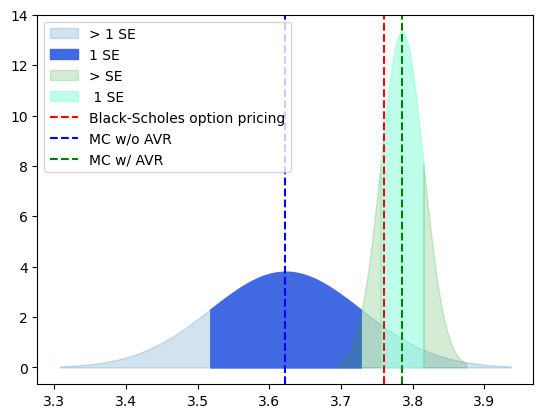

In [253]:
St1[St1 <= 0] = 0 
St2[St2 <= 0] = 0 
S = 0.5 * (St1 + St2)
SE2 = S.std(ddof= 1) / np.sqrt(d)

x1 = np.linspace(C0_MC - 3 * SE1, C0_MC - 1 * SE1, 100)
X1 = np.linspace(C0_MC_AVR - 3 * SE2, C0_MC_AVR - 1 * SE2, 100)
x2 = np.linspace(C0_MC - 1 * SE1, C0_MC + 1 * SE1, 100)
X2 = np.linspace(C0_MC_AVR - 1 * SE2, C0_MC_AVR + 1 * SE2, 100)
x3 = np.linspace(C0_MC + 1 * SE1, C0_MC + 3 * SE1, 100)
X3 = np.linspace(C0_MC_AVR + 1 * SE2, C0_MC_AVR + 3 * SE2, 100)

y1 = ss.norm.pdf(x1, C0_MC, SE1)
Y1 = ss.norm.pdf(X1, C0_MC_AVR, SE2)
y2 = ss.norm.pdf(x2, C0_MC, SE1)
Y2 = ss.norm.pdf(X2, C0_MC_AVR, SE2)
y3 = ss.norm.pdf(x3, C0_MC, SE1)
Y3 = ss.norm.pdf(X3, C0_MC_AVR, SE2) 

plt.fill_between(x1, y1, color = 'tab:blue', label = '> 1 SE', alpha = 0.2)
plt.fill_between(x2, y2, color = 'royalblue', alpha = 1, label = '1 SE')
plt.fill_between(x3, y3, color = 'tab:blue', alpha = 0.2)

plt.fill_between(X1, Y1, color = 'tab:green', label = '> SE', alpha = 0.2)
plt.fill_between(X2, Y2, color = 'aquamarine', label = ' 1 SE', alpha = 0.5)
plt.fill_between(X3, Y3, color = 'tab:green', alpha = 0.2)

plt.axvline(x = C0_BS, color = 'r', linestyle = 'dashed', label = 'Black-Scholes option pricing')
plt.axvline(x = C0_MC, color = 'blue', linestyle = 'dashed', label = 'MC w/o AVR')
plt.axvline(x = C0_MC_AVR, color = 'green', linestyle = 'dashed', label = 'MC w/ AVR')
plt.legend()plt.show()

## Conclusions:
It is evident that the AVR method significantly increases the efficiency and effectiveness of MC simulation to value an option.